This is early experimenting with importing real world data, playing around with our existing code, and determining how/if h5py (HDF5) file format will be appropriate for our needs.

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ramannoodles import spectrafit

In [2]:
CO_data = pd.read_excel('../../Baseline Subtracted Data/CarbonMonoxide_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
Me_data = pd.read_excel('../../Baseline Subtracted Data/Methane_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
H_data = pd.read_excel('../../Baseline Subtracted Data/Hydrogen_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
FA_data = pd.read_excel('../../FormicAcid_3percentconc_400C_5s_00000.xlsx',
                        header=None, names=('x', 'y'))

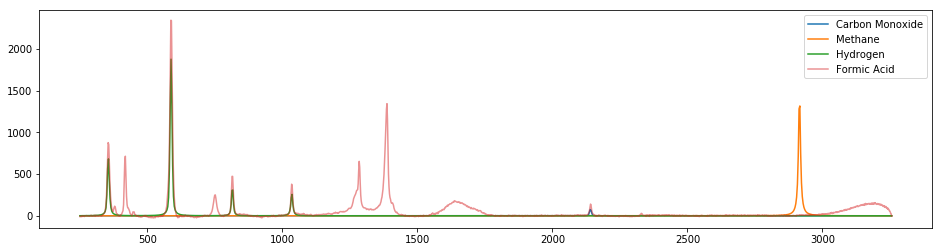

In [3]:
plt.figure(figsize=(16,4))
plt.plot(CO_data['x'], CO_data['y'], label='Carbon Monoxide')
plt.plot(Me_data['x'], Me_data['y'], label='Methane')
plt.plot(H_data['x'], H_data['y'], label='Hydrogen')
plt.plot(FA_data['x'], FA_data['y'], label='Formic Acid', alpha = 0.5)
plt.legend()

In [4]:
data = Me_data

In [5]:
peaks, peak_list1 = spectrafit.peak_detect(data['x'].values, data['y'].values, height=10, prominence=20)
peaks

[(2916.19781781782, 1316.97902477351)]

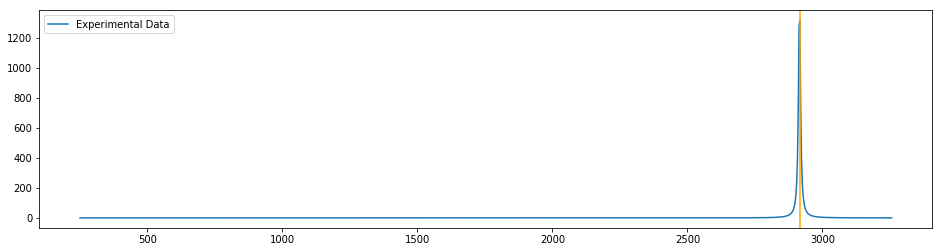

In [6]:
plt.figure(figsize=(16,4))
plt.plot(data['x'], data['y'], label='Experimental Data')
for i in peak_list1[0]:
    plt.axvline(x=data['x'][i], color='orange')
plt.legend()

In [7]:
# from lmfit.models import LorentzianModel
# from lmfit.models import GaussianModel
# from lmfit.models import VoigtModel
# from lmfit.models import PseudoVoigtModel

In [8]:
# peak_list = []
# for i, _ in enumerate(peaks):
#     prefix = 'p{}_'.format(i+1)
#     peak = PseudoVoigtModel(prefix=prefix)
#     if i == 0:
#         pars = peak.make_params()
#     else:
#         pars.update(peak.make_params())
#     pars[prefix+'center'].set(peaks[i][0], vary=False,
#                               min=(peaks[i][0]-10), max=(peaks[i][0]+10))
#     pars[prefix+'height'].set(peaks[i][1], vary=False)
#     pars[prefix+'sigma'].set(50, min=0, max=500)
#     pars[prefix+'amplitude'].set(min=0)
#     peak_list.append(peak)
#     if i == 0:
#         mod = peak_list[i]
#     else:
#         mod = mod + peak_list[i]

In [ ]:
mod, pars = spectrafit.set_params(peaks) 

In [10]:
out = spectrafit.model_fit(data['x'].values, data['y'].values, mod, pars)
print(out.fit_report())

[[Model]]
    Model(pvoigt, prefix='p1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 1000
    # variables        = 3
    chi-square         = 209784.785
    reduced chi-square = 210.416033
    Akaike info crit   = 5352.08217
    Bayesian info crit = 5366.80544
[[Variables]]
    p1_fraction:   0.89072074 +/- 0.03169382 (3.56%) (init = 0.5)
    p1_sigma:      5.21385545 +/- 0.08887432 (1.70%) (init = 50)
    p1_center:     2916.198 (fixed)
    p1_amplitude:  20636.0467 +/- 238.674195 (1.16%) (init = 1)
    p1_fwhm:       10.4277109 +/- 0.17774864 (1.70%) == '2.0000000*p1_sigma'
    p1_height:     1316.979 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(p1_fraction, p1_sigma)     = -0.671
    C(p1_fraction, p1_amplitude) =  0.605



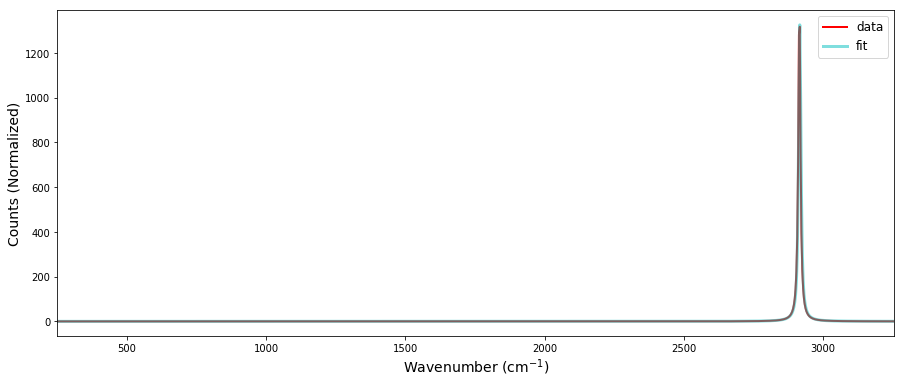

In [11]:
spectrafit.plot_fit(data['x'].values, data['y'].values, out, plot_components=False)

Using our existing code with the baselined single compound data the curve fitting appears to work well. Expecially when a Voigt or Pseudo-Voigt model is used opposed to the Lorentzian. Next we begin to experiment with h5py (HDF5 file format) for storing the data and the result of the curve fitting for future comparison with multi-compound spectra.

In [12]:
f = h5py.File("Hydrogen_test.hdf5", "w")

In [13]:
f['data/x'] = H_data['x']

In [14]:
f['data/y'] = H_data['y']
f['compound'] = 'Hydrogren'

In [15]:
list(f.keys())

['compound', 'data']

In [16]:
x_data = f['data/x'][:]

In [17]:
H_fit = spectrafit.export_fit_data(out)

In [18]:
H_fit

[array([8.90720744e-01, 5.21385545e+00, 2.91619782e+03, 2.06360467e+04,
        1.04277109e+01, 1.31697902e+03])]

In [19]:
list(f['data'].keys())

['x', 'y']

In [20]:
for i, _ in enumerate(H_fit):
    f['peak/{}'.format(i+1)] = H_fit[i]

In [21]:
list(f['peak/1'])

[0.8907207444654803,
 5.213855449126975,
 2916.19781781782,
 20636.046727482157,
 10.42771089825395,
 1316.97902477351]

In [22]:
dic = {'one':1, 'two':2, 'three':3}
dic

{'one': 1, 'two': 2, 'three': 3}

In [23]:
f['test/one'] = 1
f['test/two'] = 2
f['test/three'] = 3

In [24]:
list(f['test'].values())

[<HDF5 dataset "one": shape (), type "<i8">,
 <HDF5 dataset "three": shape (), type "<i8">,
 <HDF5 dataset "two": shape (), type "<i8">]

In [32]:
"""
This is the unit test module for spectrafit.py
"""

import pickle
import numpy as np
import lmfit
from ramannoodles import spectrafit


# define gaussian function used to generate test data (fake spectra)
def gaussian(x_input, var_a, var_b, var_c):
    """Simple function to produce a gaussian distribution"""
    y_output = var_a*np.exp(-((x_input-var_b)**2)/(2*(var_c**2)))
    return y_output


# generate test data
X_TEST = np.arange(500, 3500, 5)
# generate 6 gaussians
GAUSS1 = gaussian(X_TEST, 0.9, 2000, 100)
GAUSS2 = gaussian(X_TEST, 0.5, 1000, 200)
GAUSS3 = gaussian(X_TEST, 0.4, 2500, 1000)
GAUSS4 = gaussian(X_TEST, 0.7, 3200, 50)
GAUSS5 = gaussian(X_TEST, 0.7, 2200, 20)
GAUSS6 = gaussian(X_TEST, 0.7, 4000, 500)
# add gaussians to create fake spectra
Y_TEST = GAUSS1 + GAUSS2 + GAUSS3 + GAUSS4 + GAUSS5 + GAUSS6
# normalize test spectra
Y_TEST = [(Y_TEST[i] - min(Y_TEST))/(max(Y_TEST)-min(Y_TEST)) for i in range(len(Y_TEST))]
Y_TEST = np.asarray(Y_TEST)

"""
Test function that confirms spectrafit.export_fit_data behaves as expected. It confirms that the
output type is correct, that the output shape is correct, that the number of peaks in the report
is correct, and the input type errors are handled.
"""
y_test = spectrafit.subtract_baseline(Y_TEST)
peaks = spectrafit.peak_detect(X_TEST, y_test)[0]
mod, pars = spectrafit.set_params(peaks)
out = spectrafit.model_fit(X_TEST, y_test, mod, pars)
fit_peak_data = spectrafit.export_fit_data(out)
assert isinstance(fit_peak_data, list), 'output is not a list'
assert np.asarray(fit_peak_data).shape == (int(len(out.values)/6), 6), """
output is not the correct shape"""
assert len(fit_peak_data) == int(len(out.values)/6), 'incorrect number of peaks exported'
try:
    spectrafit.export_fit_data(mod)
except TypeError:
    print('A str was passed to the function, and was handled well with a TypeError.')
np.asarray(fit_peak_data).shape

A str was passed to the function, and was handled well with a TypeError.


(4, 6)

In [31]:
int(len(out.values)/6)

4